### Data Collection

1. Define Classes & Functions <br>
    a. Get list of SEC docs for CIK<br>
    b. Extract text, date, item numbers from each link<br>
    c. Get price given ticker, data from AlphaVantage<br>
    d. Get movement given ticker, date<br>
    e. Get index movement<br>
    f. Check if date is a weekday, and if necessary, adjust to Friday before<br>
    g. Calculate dates for month before, quarter before, year before for historical movement calculations
2. GET S&P 500 company info<br>
3. Get list of 8K doc links <br>
4. Download 8Ks & Stock Movements<br>

In [6]:
from bs4 import BeautifulSoup
import datetime
import unicodedata
import requests
import pandas as pd
import numpy as np
from time import sleep
import math
from config import Config
import dateutil.relativedelta
import pandas_market_calendars as mcal
import os
import io
import re
from tqdm import tqdm
import gc

### 1 Define Functions and Classes

In [2]:
from bs4 import BeautifulSoup
import datetime
import unicodedata
import requests
import pandas as pd
import numpy as np
from time import sleep
import re

class SEC_Extractor:
    def get_doc_links(cik,ticker):
        try:
            base_url = "https://www.sec.gov/cgi-bin/browse-edgar"
            inputted_cik = cik
            payload = {
                "action" : "getcompany",
                "CIK" : inputted_cik,
                "type" : "8-K",
                "output":"xml",
                "dateb" : "20180401",
            }
            sec_response = requests.get(url=base_url,params=payload)
            soup = BeautifulSoup(sec_response.text,'lxml')
            url_list = soup.findAll('filinghref')
            html_list = []
            # Get html version of links
            for link in url_list:
                link = link.string
                if link.split(".")[len(link.split("."))-1] == 'htm':
                    txtlink = link + "l"
                    html_list.append(txtlink)

            doc_list = []
            doc_name_list = []
            # Get links for txt versions of files
            for k in range(len(html_list)):
                txt_doc = html_list[k].replace("-index.html",".txt")
                doc_name = txt_doc.split("/")[-1]
                doc_list.append(txt_doc)
                doc_name_list.append(doc_name)
                # Create dataframe of CIK, doc name, and txt link
            df = pd.DataFrame(
                {
                "cik" : [cik]*len(html_list),
                "ticker" : [ticker]*len(html_list),
                "txt_link" : doc_list,
                "doc_name": doc_name_list
                }
            )
        except requests.exceptions.ConnectionError:
                sleep(.1)
        return df

    # Extracts text and submission datetime from document link
    def extract_text(link):
        try:
            r = requests.get(link)
            #Parse 8-K document
            filing = BeautifulSoup(r.content,"html5lib",from_encoding="ascii")
            #Extract datetime
            try:
                submission_dt = filing.find("acceptance-datetime").string[:14]
            except AttributeError:
                    # Flag docs with missing data as May 1 2018 10AM
                submission_dt = "20180501100000"
            
            submission_dt = datetime.datetime.strptime(submission_dt,"%Y%m%d%H%M%S")
            #Extract HTML sections
            for section in filing.findAll("html"):
                try:
                    #Remove tables
                    for table in section("table"):
                        table.decompose()
                    #Convert to unicode
                    section = unicodedata.normalize("NFKD",section.text)
                    section = section.replace("\t"," ").replace("\n"," ").replace("/s"," ").replace("\'","'")            
                except AttributeError:
                    section = str(section.encode('utf-8'))
            filing = "".join((section))
        except requests.exceptions.ConnectionError:
                sleep(10)
        sleep(.1)

        return filing, submission_dt

    def extract_item_no(document):
        pattern = re.compile("Item+ +\d+[\:,\.]+\d+\d")
        item_list = re.findall(pattern,document)
        return item_list


In [3]:
# Returns Dataframe of document links for a given CIK
idx = pd.Index
class FinDataExtractor:
    def __init__(self):
        # S&P 500 index data downloaded from Yahoo Finance GSPC
        self.gspc_df = pd.read_csv("Data/Indexes/gspc.csv",parse_dates=['Date'],index_col="Date")
        # Get VIX index data downloaded from Yahoo Finance
        self.vix_df = pd.read_csv("Data/Indexes/vix.csv",parse_dates=['Date'],index_col="Date")
        nyse = mcal.get_calendar('NYSE')
        self.nyse_holidays = nyse.holidays().holidays
        self.all_tickers_data = pd.read_pickle("Pickles/all_tickers_data.pkl")
        
#Takes datetime object and ticker string, returns price (opening or closing)
    def get_historical_movements(self,row,period):
        ticker,release_date = row[0],row[1]

       #1 Week
        if period == "week":
            e_start = release_date + datetime.timedelta(weeks=-1)
            b_start = e_start

            e_end = release_date + dateutil.relativedelta.relativedelta(days=-1)
            b_end = e_end

         #1 Month    
        elif period == "month":
            e_start = release_date + dateutil.relativedelta.relativedelta(months=-1)
            b_start = e_start + dateutil.relativedelta.relativedelta(days=-5)

            e_end = release_date + dateutil.relativedelta.relativedelta(days=-1)
            b_end = release_date + dateutil.relativedelta.relativedelta(days=-6)

        #1 Quarter
        elif period == "quarter":
            e_start = release_date + dateutil.relativedelta.relativedelta(months=-3)
            b_start = e_start + dateutil.relativedelta.relativedelta(days=-10)

            e_end = release_date + dateutil.relativedelta.relativedelta(days=-1)
            b_end = release_date + dateutil.relativedelta.relativedelta(days=-11)

        #1 Year
        elif period == "year":
            e_start = release_date + dateutil.relativedelta.relativedelta(years=-1)
            b_start = e_start + dateutil.relativedelta.relativedelta(days=-20)

            e_end = release_date + dateutil.relativedelta.relativedelta(days=-1)
            b_end = release_date + dateutil.relativedelta.relativedelta(days=-21)
        else:
            raise KeyError

        e_start = self.weekday_check(e_start)
        b_start = self.weekday_check(b_start)
        e_end = self.weekday_check(e_end)
        b_end = self.weekday_check(b_end)

        start_price = self.get_av_data(ticker=ticker,start_date = b_start, end_date = e_start)
        end_price = self.get_av_data(ticker=ticker,start_date = b_end, end_date = e_end)
        stock_change = self.calculate_pct_change(end_price,start_price)

        start_index = self.get_index_price(start_date = b_start, end_date = e_start)
        end_index = self.get_index_price(start_date = e_start, end_date = e_end)
        index_change =  self.calculate_pct_change(end_index,start_index)

        normalized = stock_change - index_change
        return normalized

    def get_av_data(self,ticker,start_date,end_date,market_open=False):
        start_date = start_date.date()
        end_date = end_date.date()

        try:
            if market_open == False:
                price = self.all_tickers_data.xs(ticker,0).loc[end_date:start_date,"adjusted_close"].mean()
            else:
                price = self.all_tickers_data.xs(ticker,0).loc[end_date:start_date,"open"].mean()
        except (KeyError,IndexError):
            price = np.nan
        return price

    # Takes ticker, 8K release date, checks time of release and then calculate before and after price change
    def get_change(self,row):
        release_date = row[1]
        ticker = row[0]
        market_close = release_date.replace(hour=16,minute=0,second=0)
        market_open = release_date.replace(hour=9,minute=30,second=0)

    # If report is released after market hours, take change of start date close and release date open
        if release_date > market_close:
            start_date = release_date
            end_date = release_date + datetime.timedelta(days=1)
            end_date = self.weekday_check(end_date)

            price_before_release = self.get_av_data(ticker,start_date,start_date,market_open=False)
            price_after_release = self.get_av_data(ticker,end_date,end_date,market_open=True)

            index_before_release = self.get_index_price(start_date,start_date,market_open=False)
            index_after_release = self.get_index_price(end_date,end_date,market_open=True)

            try:
                vix = self.vix_df.loc[self.vix_df.index == np.datetime64(start_date.date()),"Adj Close"][0].item()
            except IndexError:
                vix = np.nan

        # If report is released before market hours, take change of start date's close and release date's open
        elif release_date < market_open:
            start_date = release_date + datetime.timedelta(days=-1)
            start_date = self.weekday_check(start_date)
            end_date = release_date

            price_before_release = self.get_av_data(ticker,start_date,start_date,market_open=False)
            price_after_release = self.get_av_data(ticker,end_date,end_date,market_open=True) 

            index_before_release = self.get_index_price(start_date,start_date,market_open=False)
            index_after_release = self.get_index_price(end_date,end_date,market_open=True)
            try:
                vix = self.vix_df.loc[self.vix_df.index == np.datetime64(start_date.date()),"Adj Close"][0].item()
            except IndexError:
                vix = np.nan
        # If report is released during market hours, use market close
        else:
            start_date = release_date
            end_date = release_date
            price_before_release = self.get_av_data(ticker,start_date,start_date,market_open=True)
            price_after_release = self.get_av_data(ticker,end_date,end_date,market_open=False)

            index_before_release = self.get_index_price(start_date,start_date,market_open=True)
            index_after_release = self.get_index_price(end_date,end_date,market_open=False)
            
            try:
                vix = self.vix_df.loc[self.vix_df.index == np.datetime64(start_date.date()),"Open"][0].item()
            except IndexError:
                vix = np.nan
                
        price_pct_change = self.calculate_pct_change(price_after_release,price_before_release)
        index_pct_change = self.calculate_pct_change(index_after_release,index_before_release)
        normalized_change = price_pct_change - index_pct_change

        return normalized_change, vix

    def get_index_price(self,start_date,end_date,market_open=False):
        try:
            if market_open == True:
                price = self.gspc_df.loc[(self.gspc_df.index >= np.datetime64(start_date.date())) & 
                                 (self.gspc_df.index <= np.datetime64(end_date)),"Open"].mean()
            else:
                price = self.gspc_df.loc[(self.gspc_df.index >= np.datetime64(start_date.date())) & 
                                 (self.gspc_df.index <= np.datetime64(end_date)),"Adj Close"].mean()
        except IndexError:
                price = np.nan
        return price

    def calculate_pct_change(self,end_value,start_value):
        pct_change = (end_value - start_value) / start_value
        pct_change = round(pct_change,4) * 100
        return pct_change

    def weekday_check(self,date):  
        while date.isoweekday() > 5 or date.date() in self.nyse_holidays:
            date = date + datetime.timedelta(days=-1)
        return date

### 2. Get S&P 500 Data

In [4]:
# Get table of the S&P 500 tickers, CIK, and industry from Wikipedia
wiki_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
cik_df = pd.read_html(wiki_url,header=[0],index_col=0)[0]
cik_df['GICS Sector'] = cik_df['GICS Sector'].astype("category")
cik_df['GICS Sub Industry'] = cik_df['GICS Sector'].astype("category")
cik_df.head()

,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added[3][4],CIK
Ticker symbol,,,,,,,
MMM,3M Company,reports,Industrials,Industrials,"St. Paul, Minnesota",NaN,66740
ABT,Abbott Laboratories,reports,Health Care,Health Care,"North Chicago, Illinois",1964-03-31,1800
ABBV,AbbVie Inc.,reports,Health Care,Health Care,"North Chicago, Illinois",2012-12-31,1551152
ACN,Accenture plc,reports,Information Technology,Information Technology,"Dublin, Ireland",2011-07-06,1467373
ATVI,Activision Blizzard,reports,Information Technology,Information Technology,"Santa Monica, California",2015-08-31,718877


### 3. Get List of 8K links from SEC Edgar

In [5]:
sec_ext = SEC_Extractor
no_parts = 2
part_no = 3

In [218]:
df_list = []
company_list = cik_df['CIK'].to_dict()
for (ticker,cik) in tqdm(company_list.items()):
    df_list.append(sec_ext.get_doc_links(cik,ticker))
doc_links_df = pd.concat(df_list,axis=0)
doc_links_df = doc_links_df.set_index("ticker").join(cik_df['GICS Sector']).join(cik_df['GICS Sub Industry']).reset_index().rename(columns={"index":"ticker"})
doc_links_df.head()

 37%|███▋      | 189/505 [01:30<02:31,  2.09it/s]

UnboundLocalError: local variable 'df' referenced before assignment

In [7]:
doc_links_df.to_pickle("Pickles/doc_links_df.pkl")

### 4. Download 8Ks & Stock Movements

In [8]:
while part_no > no_parts:
    no_parts = int(input("Split data into how many parts?"))
    part_no = int(input("Which part is this?"))
    
chunksize = int(input("Number of rows to process at once (10 to 50 recommended)"))

#Load pickle
crawled_df = np.array_split(pd.read_pickle("Pickles/doc_links_df.pkl"),no_parts)[part_no-1][:10]
crawled_len = len(crawled_df['txt_link'])
chunks = math.ceil(crawled_len/chunksize)

df_list = []
for i, df in tqdm(enumerate(np.array_split(crawled_df,chunks))):
    df['text'], df['release_date'] = zip(*df['txt_link'].apply(sec_ext.extract_text))
    df['items'] = df['text'].map(sec_ext.extract_item_no)
    if not os.path.isfile("Data/texts_example{}.csv.gzip".format(part_no)): #If no file exists, create one with header
        df.to_csv("Data/texts_example{}.csv.gzip".format(part_no),chunksize=chunksize,compression="gzip")
    else: # else it exists so append without writing the header
        df.to_csv("Data/texts_example{}.csv.gzip".format(part_no),mode="a",header=False,compression="gzip",chunksize=chunksize)       
    df_list.append(df)
    del df
    
    if i % 50 == 0:
        gc.collect()
df = pd.concat(df_list)
df.head()

Split data into how many parts?1
Which part is this?1
Number of rows to process at once (10 to 50 recommended)1


10it [00:15,  1.56s/it]


,ticker,cik,doc_name,txt_link,GICS Sector,GICS Sub Industry,text,release_date,items
0,A,1090872,0001564590-18-006570.txt,http://www.sec.gov/Archives/edgar/data/1090872...,Health Care,Health Care,0001564590-18-006570.txt : 20180322 0001564590...,2018-03-22 16:22:07,[Item 5.07]
1,A,1090872,0001090872-18-000002.txt,http://www.sec.gov/Archives/edgar/data/1090872...,Health Care,Health Care,0001090872-18-000002.txt : 20180214 0001090872...,2018-02-14 16:27:02,"[Item 2.02, Item 2.02, Item 9.01]"
2,A,1090872,0001564590-18-000605.txt,http://www.sec.gov/Archives/edgar/data/1090872...,Health Care,Health Care,0001564590-18-000605.txt : 20180118 0001564590...,2018-01-18 16:09:52,"[Item 5.02, Item 9.01]"
3,A,1090872,0001090872-17-000015.txt,http://www.sec.gov/Archives/edgar/data/1090872...,Health Care,Health Care,0001090872-17-000015.txt : 20171120 0001090872...,2017-11-20 16:09:02,"[Item 2.02, Item 2.02, Item 9.01]"
4,A,1090872,0001090872-17-000011.txt,http://www.sec.gov/Archives/edgar/data/1090872...,Health Care,Health Care,0001090872-17-000011.txt : 20170815 0001090872...,2017-08-15 16:12:29,"[Item 2.02, Item 2.02, Item 9.01]"


### Load Financial Data

In [ ]:
df1 = pd.read_csv("Data/texts1.csv.gzip",compression="gzip",parse_dates=['release_date'])
df2 = pd.read_csv("Data/texts2.csv.gzip",compression="gzip",parse_dates=['release_date'])
df = pd.concat([df1,df2],axis=0)
df['items'] = df['items'].map(lambda x: ast.literal_eval(x))



In [170]:
fin_data = FinDataExtractor()
## Load pickle of ticker, date, and doc number

df[['price_change','vix']] = df[['ticker','release_date']].apply(fin_data.get_change,axis=1,broadcast=True)
df['rm_week'] = df[['ticker','release_date']].apply(fin_data.get_historical_movements,period="week",axis=1)
df['rm_month'] = df[['ticker','release_date']].apply(fin_data.get_historical_movements,period="month",axis=1)
df['rm_qtr'] = df[['ticker','release_date']].apply(fin_data.get_historical_movements,period="quarter",axis=1)
df['rm_year'] = df[['ticker','release_date']].apply(fin_data.get_historical_movements,period="year",axis=1)
df["signal"] = df['price_change'].map(lambda x: "stay" if -1<x<1 else ("up" if x>1 else "down"))
df.head()

In [153]:
df.head()

,Unnamed: 0,ticker,cik,doc_name,txt_link,GICS Sector,GICS Sub Industry,text,release_date,items,price_change,vix,rm_week,rm_month,rm_qtr,rm_year,signal,processed_text,text_len
0,0,A,1090872,0001564590-18-006570.txt,http://www.sec.gov/Archives/edgar/data/1090872...,Health Care,Health Care,0001564590-18-006570.txt : 20180322 0001564590...,2018-03-22 16:22:07,[Item 5.07],0.05,23.34,-0.41,-3.07,1.78,26.37,stay,accession number conformed submission type pub...,312
1,1,A,1090872,0001090872-18-000002.txt,http://www.sec.gov/Archives/edgar/data/1090872...,Health Care,Health Care,0001090872-18-000002.txt : 20180214 0001090872...,2018-02-14 16:27:02,"[Item 2.02, Item 2.02, Item 9.01]",6.97,19.26,1.95,-5.76,-3.62,35.35,up,accession number conformed submission type pub...,2103
2,2,A,1090872,0001564590-18-000605.txt,http://www.sec.gov/Archives/edgar/data/1090872...,Health Care,Health Care,0001564590-18-000605.txt : 20180118 0001564590...,2018-01-18 16:09:52,"[Item 5.02, Item 9.01]",0.24,12.22,1.22,4.93,3.15,38.90,stay,accession number conformed submission type pub...,835
3,3,A,1090872,0001090872-17-000015.txt,http://www.sec.gov/Archives/edgar/data/1090872...,Health Care,Health Care,0001090872-17-000015.txt : 20171120 0001090872...,2017-11-20 16:09:02,"[Item 2.02, Item 2.02, Item 9.01]",-0.14,10.65,2.71,1.31,9.54,39.85,stay,accession number conformed submission type pub...,1887
4,4,A,1090872,0001090872-17-000011.txt,http://www.sec.gov/Archives/edgar/data/1090872...,Health Care,Health Care,0001090872-17-000011.txt : 20170815 0001090872...,2017-08-15 16:12:29,"[Item 2.02, Item 2.02, Item 9.01]",4.50,12.04,-0.21,-3.34,4.39,21.40,up,accession number conformed submission type pub...,1916


In [160]:
import ast

df = pd.read_csv("Data/texts1.csv.gzip",compression="gzip",parse_dates=['release_date'])
df["signal"] = df['price_change'].map(lambda x: "stay" if -1<x<1 else ("up" if x>1 else "down"))
df['items'] = df['items'].map(lambda x: ast.literal_eval(x))
df.shape

(5, 17)

In [164]:
# Find rows flagged where no date was found
df['release_date'].loc[df['release_date'] >= pd.datetime(year=2018,month=5,day=1)]

0   2018-03-22 16:22:07
1   2018-02-14 16:27:02
2   2018-01-18 16:09:52
3   2017-11-20 16:09:02
4   2017-08-15 16:12:29
Name: release_date, dtype: datetime64[ns]

In [168]:
## Find duplicates
df.loc[df.duplicated(subset='doc_name')]

,Unnamed: 0,ticker,cik,doc_name,txt_link,GICS Sector,GICS Sub Industry,text,release_date,items,price_change,vix,rm_week,rm_month,rm_qtr,rm_year,signal


## Text PreProcessing
1. Remove extra whitespace
2. Tokenize
3. Remove punctuation, stopwords, convert to lower case
4. Lemmatize
5. Load pre-trained word embeddings

In [23]:
import spacy
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import seaborn as sns
stop_words = stopwords.words("english")
nlp = spacy.load("en_core_web_sm")
punctuations = string.punctuation

In [24]:
def cleanup_text(doc, logging=False):
    doc = re.sub( '\s+', ' ', doc ).strip()
    doc = nlp(doc, disable=['parser', 'ner'])
    tokens = [tok.lemma_.lower().strip() for tok in doc]
    tokens = [tok for tok in tokens if tok.isalpha()]
    tokens = [tok for tok in tokens if tok not in stop_words and tok not in punctuations]
    tokens_len = len(tokens)
    tokens = ' '.join(tokens)
    return tokens,tokens_len

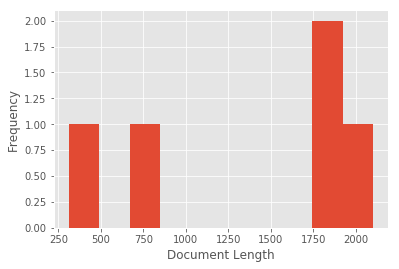

In [25]:
df['processed_text'],df['text_len'] = zip(*df['text'].apply(cleanup_text))
plt.style.use("ggplot")
df['text_len'].plot.hist()
plt.xlabel("Document Length")
plt.show()

In [26]:
df['text_len'].describe()

count       5.000000
mean     1410.600000
std       790.575929
min       312.000000
25%       835.000000
50%      1887.000000
75%      1916.000000
max      2103.000000
Name: text_len, dtype: float64

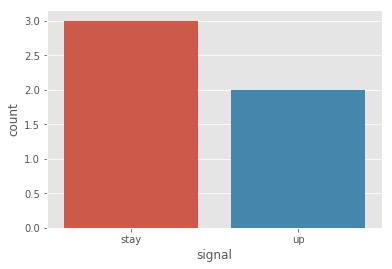

In [27]:
#Count plot of signals
sns.countplot(df['signal'])
plt.show()

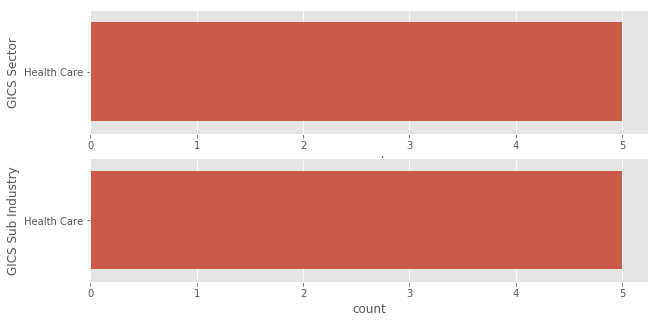

In [28]:
plt.figure(figsize=[10,5])
plt.subplot(211)
sns.countplot(y=df['GICS Sector'])

plt.subplot(212)
sns.countplot(y=df['GICS Sub Industry'])

plt.show()

### Machine Learning Models

1. Preprocess dataframe
2. Load Word Embeddings


In [129]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU,Input, LSTM, Embedding, Bidirectional
from keras.layers import Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, TimeDistributed, BatchNormalization
from keras.layers import concatenate as lconcat
from keras.optimizers import SGD
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from sklearn.metrics import roc_auc_score
from keras.utils import np_utils,plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler

In [61]:
#### Define number of words, and embedding dimensions
max_words = 2000
embed_dim = 100

def load_embeddings(vec_file):
    print("Loading Glove Model")
    f = open(vec_file,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done. {} words loaded!".format(len(model)))
    return model

def tokenize_and_pad(docs,max_words=max_words):
    global t
    t = Tokenizer()
    t.fit_on_texts(docs)
    docs = pad_sequences(sequences = t.texts_to_sequences(docs),maxlen = max_words, padding = 'post')
    global vocab_size
    vocab_size = len(t.word_index)+1
    return docs

In [62]:
# Separate into X and Y
X = df[['GICS Sector','vix','rm_week','rm_month', 'rm_qtr', 'rm_year', 'items']]
docs = df['processed_text']
docs = tokenize_and_pad(docs)
y = df['signal']

# Get Dummies
mlb = MultiLabelBinarizer()
X = X.join(pd.DataFrame(mlb.fit_transform(X.pop('items')),columns=mlb.classes_,index=X.index))
X = pd.get_dummies(columns = ['GICS Sector'],prefix="sector",data=X)
y = pd.get_dummies(columns=['signal'],data=y)

aux_shape = len(X.columns)

# Split into train and test data
X_train, X_test, y_train, y_test, docs_train, docs_test = train_test_split(X, y,docs,
                                                    stratify=y, 
                                                    test_size=0.3,
                                                    random_state = 20)

In [47]:
embeddings_index = load_embeddings("glove.6B.100d.txt")

Loading Glove Model
Done. 400000 words loaded!


In [63]:
words_not_found = []

embedding_matrix = np.zeros((vocab_size, embed_dim))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

number of null word embeddings: 20


In [64]:
cont_features = ['vix','rm_week','rm_month', 'rm_qtr', 'rm_year']
aux_features = cont_features + [item for item in mlb.classes_]
x_scaler = StandardScaler()
X_train[cont_features] = x_scaler.fit_transform(X_train[cont_features])
X_test[cont_features] = x_scaler.transform(X_test[cont_features])

cv = StratifiedShuffleSplit(n_splits=5,test_size=.2,random_state=1)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [142]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.callbacks import Callback, EarlyStopping


# define roc_callback, inspired by https://github.com/keras-team/keras/issues/6050#issuecomment-329996505
def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.metrics.auc(y_true,y_pred)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

In [143]:
def build_model(output_classes,architecture,aux_shape=aux_shape,vocab_size=vocab_size,embed_dim=embed_dim,embedding_matrix=embedding_matrix,max_seq_len=max_words):
    main_input= Input(shape=(max_seq_len,),name='doc_input')
    main = Embedding(input_dim = vocab_size,
                        output_dim = embed_dim,
                        weights=[embedding_matrix], 
                        input_length=max_seq_len, 
                        trainable=False)(main_input)
    
    if architecture == 'mlp':
        # Densely Connected Neural Network (Multi-Layer Perceptron)
        main = Dense(128, activation='relu')(main)
        main = Dropout(0.2)(main)
        main = Flatten()(main)
    elif architecture == 'cnn':
        # 1-D Convolutional Neural Network
        main = Conv1D(128, 3, strides=1, padding='same', activation='relu')(main)
        #Cuts the size of the output in half, maxing over every 2 inputs
        main = MaxPooling1D(pool_size=3)(main)
        main = Dropout(0.2)(main)
        main = Conv1D(64, 3, strides=1, padding='same', activation='relu')(main)
        main = GlobalMaxPooling1D()(main)
        #model.add(Dense(output_classes, activation='softmax'))
    elif architecture == 'rnn':
        # LSTM network

        main = Bidirectional(GRU(128, return_sequences=True),
                          merge_mode='concat')(main)
        main = Dropout(0.2)(main)
        main = GlobalMaxPooling1D()(main)
        main = Dense(2, activation='softmax')(main)
    elif architecture =="rnn_cnn":
        main = Conv1D(128, 5, padding='same', activation='relu')(main)
        main = MaxPooling1D()(main)
        main = Dropout(0.2)(main)
        main = Bidirectional(GRU(100,return_sequences=True),merge_mode='concat')(main)
        main = TimeDistributed(Dense(50, activation='relu'))(main)
        main = BatchNormalization()(main)
        main = Flatten()(main)
        main = Dense(output_classes,activation="softmax")(main)
    else:
        print('Error: Model type not found.')
        
    auxiliary_input = Input(shape=(aux_shape,), name='aux_input')
    x = lconcat([main, auxiliary_input])
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    main_output = Dense(output_classes, activation='sigmoid', name='main_output')(x)
    model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output],name=architecture)
        
    #sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)    
    model.compile('adam', 'categorical_crossentropy',metrics=['accuracy',auc_roc])
    return model

def plot_metrics(model_dict,metric):
    plots = 1
    plt.figure(figsize=[15,10])
    for model, history in model_dict.items():
        plt.subplot(2,2,plots)
        plt.plot(history.history[metric])
        #plt.plot(history.history['val_acc'])
        plt.title('{0} {1}'.format(model,metric))
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plots += 1
    #plt.legend(['train', 'test'], loc='upper left')
    plt.tight_layout()
    plt.show()

In [144]:
mlp = build_model(2,"mlp")
rnn = build_model(2,"rnn")
cnn = build_model(2,"cnn")
rnn_cnn = build_model(2,"rnn_cnn")
models = [mlp,rnn,cnn,rnn_cnn]

In [145]:
epochs = 5
batch_size = 128
model_dict = dict()
for model in models:
    print(model.name)
    model_dict["{}".format(model.name)] = model.fit([docs_train,X_train],y_train,batch_size=batch_size,epochs=epochs,verbose=1) 

mlp
Epoch 1/5
3/3 [==============================] - 7s 2s/step - loss: 0.6880 - acc: 0.6667 - auc_roc: 0.0000e+00
Epoch 2/5
3/3 [==============================] - 1s 190ms/step - loss: 0.3346 - acc: 0.6667 - auc_roc: 0.6667
Epoch 3/5
3/3 [==============================] - 0s 127ms/step - loss: 0.2462 - acc: 0.6667 - auc_roc: 0.7778
Epoch 4/5
3/3 [==============================] - 0s 115ms/step - loss: 0.2311 - acc: 1.0000 - auc_roc: 0.7778
Epoch 5/5
3/3 [==============================] - 0s 115ms/step - loss: 0.2311 - acc: 0.6667 - auc_roc: 0.7917
rnn
Epoch 1/5
3/3 [==============================] - 10s 3s/step - loss: 0.7573 - acc: 0.0000e+00 - auc_roc: 0.0000e+00
Epoch 2/5
3/3 [==============================] - 3s 861ms/step - loss: 0.7338 - acc: 0.3333 - auc_roc: 0.2222
Epoch 3/5
3/3 [==============================] - 3s 909ms/step - loss: 0.6969 - acc: 0.3333 - auc_roc: 0.3472
Epoch 4/5
3/3 [==============================] - 3s 963ms/step - loss: 0.6763 - acc: 0.6667 - auc_roc: 0.

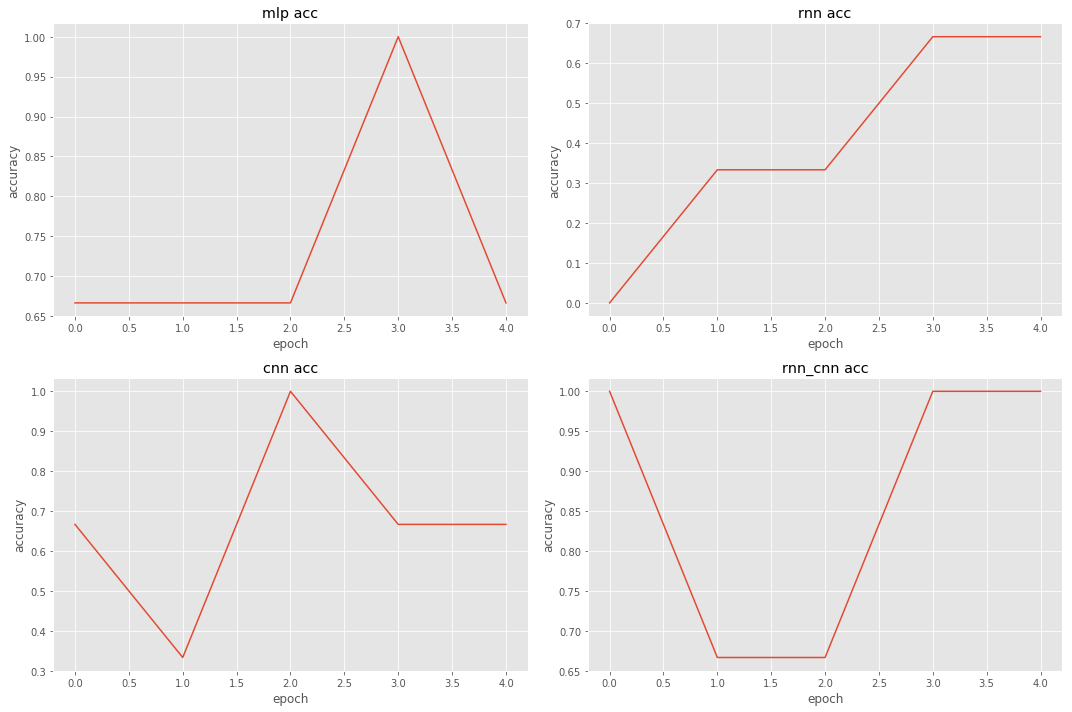

In [146]:
plot_metrics(model_dict,"acc")

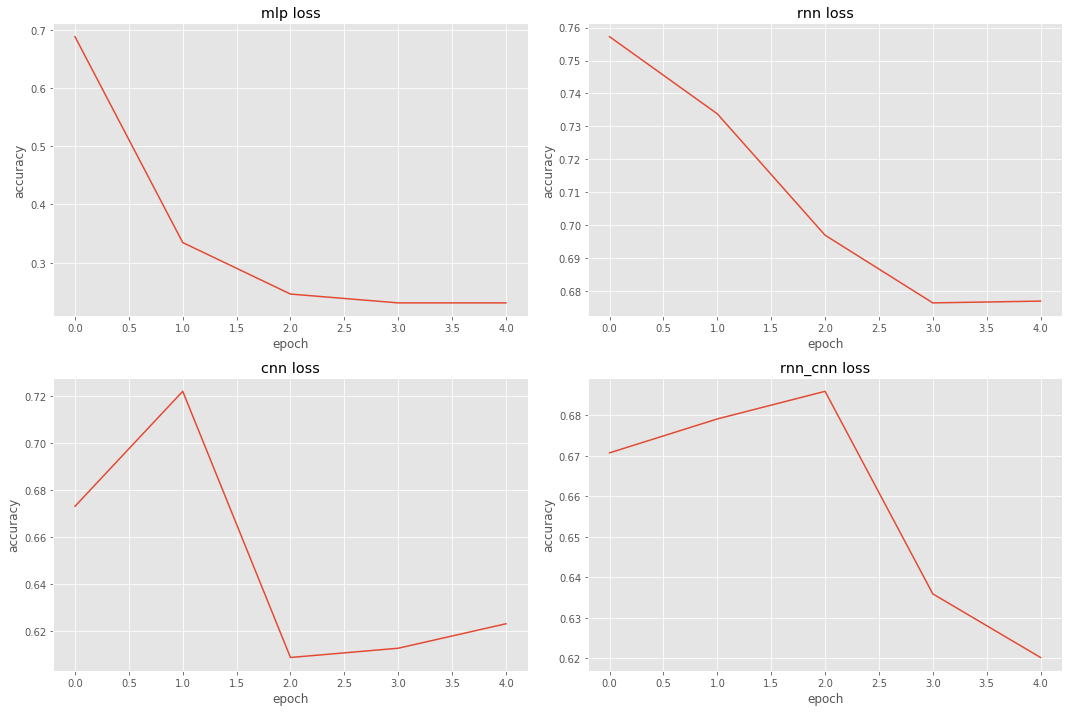

In [147]:
plot_metrics(model_dict,"loss")

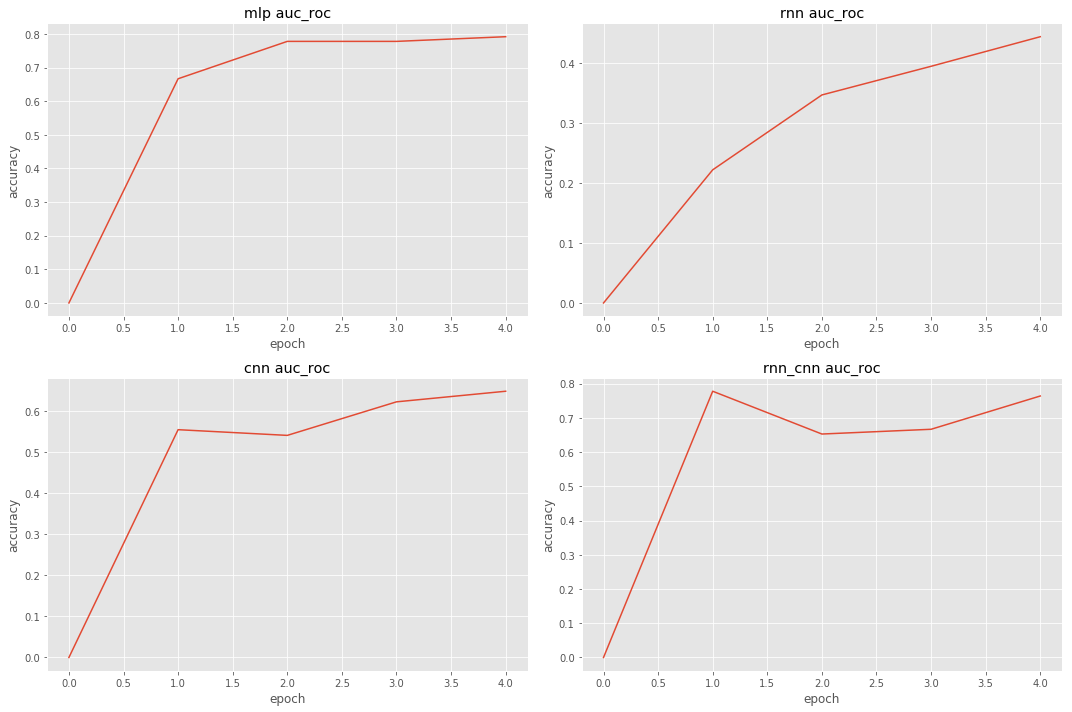

In [152]:
plot_metrics(model_dict,'auc_roc')